#Initial Set-Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, random, torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
data_src = 'solar_data_combined_cleaned.csv'
data_df = pd.read_csv(data_src)

In [3]:
data_df

,datetime,local_datetime,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,...,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs
0,2018-01-01 16:30:00,2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,...,0.347,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451
1,2018-01-01 16:40:00,2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,...,0.347,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561
2,2018-01-01 16:50:00,2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,...,0.346,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568
3,2018-01-01 17:00:00,2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,...,0.346,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596
4,2018-01-01 17:10:00,2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,...,0.345,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,2023-12-31 22:00:00,2023-12-31 15:00:00,2023,12,31,22,0,3.1,1.15,0.029,...,0.326,57.39,75.10,0.86,0.12,827,0.7,71,0.6,0.822
135552,2023-12-31 22:10:00,2023-12-31 15:10:00,2023,12,31,22,10,2.8,1.15,0.029,...,0.326,58.62,76.39,0.86,0.12,827,0.7,74,0.6,0.824
135553,2023-12-31 22:20:00,2023-12-31 15:20:00,2023,12,31,22,20,2.5,1.15,0.029,...,0.327,59.88,77.74,0.87,0.12,827,0.7,77,0.5,0.781
135554,2023-12-31 22:30:00,2023-12-31 15:30:00,2023,12,31,22,30,2.2,1.15,0.029,...,0.327,61.17,79.12,0.87,0.12,827,0.7,80,0.5,0.735


In [4]:
from copy import deepcopy as dc

data = dc(data_df)
data['local_datetime'] = pd.to_datetime(data_df['local_datetime'], errors='coerce')
data.dropna(subset=['local_datetime'], inplace=True)
data.set_index('local_datetime', inplace = True)
data.drop('datetime', axis = 1, inplace = True)
data['Target'] = data['GHI'].shift(-4)
data.dropna(inplace = True)

In [5]:
data

,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,Asymmetry,Clearsky DHI,...,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs,Target
local_datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,0.62,46,...,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451,241.0
2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,0.62,47,...,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561,253.0
2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,0.62,48,...,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568,251.0
2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,0.62,49,...,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596,273.0
2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,0.62,50,...,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:20:00,2023,12,31,21,20,4.3,1.16,0.029,0.62,50,...,46.80,70.43,0.86,0.12,827,0.6,52,1.1,0.795,203.0
2023-12-31 14:30:00,2023,12,31,21,30,4.0,1.16,0.029,0.62,49,...,47.79,71.52,0.86,0.12,827,0.6,57,1.0,0.784,183.0
2023-12-31 14:40:00,2023,12,31,21,40,3.7,1.15,0.029,0.62,47,...,55.02,72.66,0.86,0.12,827,0.7,61,0.8,0.834,153.0


In [6]:
# Calculate autocorrelation manually
max_lag = 50  # Number of lags to evaluate
autocorr_values = [data['Target'].autocorr(lag=i) for i in range(1, max_lag + 1)]

# Display results
for lag, corr in enumerate(autocorr_values, 1):
    print(f'Lag {lag}: {corr:.3f}')

Lag 1: 0.963
Lag 2: 0.932
Lag 3: 0.900
Lag 4: 0.865
Lag 5: 0.826
Lag 6: 0.784
Lag 7: 0.739
Lag 8: 0.691
Lag 9: 0.641
Lag 10: 0.588
Lag 11: 0.534
Lag 12: 0.479
Lag 13: 0.422
Lag 14: 0.365
Lag 15: 0.307
Lag 16: 0.249
Lag 17: 0.192
Lag 18: 0.136
Lag 19: 0.081
Lag 20: 0.028
Lag 21: -0.022
Lag 22: -0.071
Lag 23: -0.116
Lag 24: -0.159
Lag 25: -0.198
Lag 26: -0.234
Lag 27: -0.265
Lag 28: -0.293
Lag 29: -0.316
Lag 30: -0.335
Lag 31: -0.350
Lag 32: -0.360
Lag 33: -0.367
Lag 34: -0.368
Lag 35: -0.365
Lag 36: -0.358
Lag 37: -0.347
Lag 38: -0.332
Lag 39: -0.313
Lag 40: -0.291
Lag 41: -0.266
Lag 42: -0.237
Lag 43: -0.206
Lag 44: -0.172
Lag 45: -0.137
Lag 46: -0.099
Lag 47: -0.060
Lag 48: -0.021
Lag 49: 0.019
Lag 50: 0.060


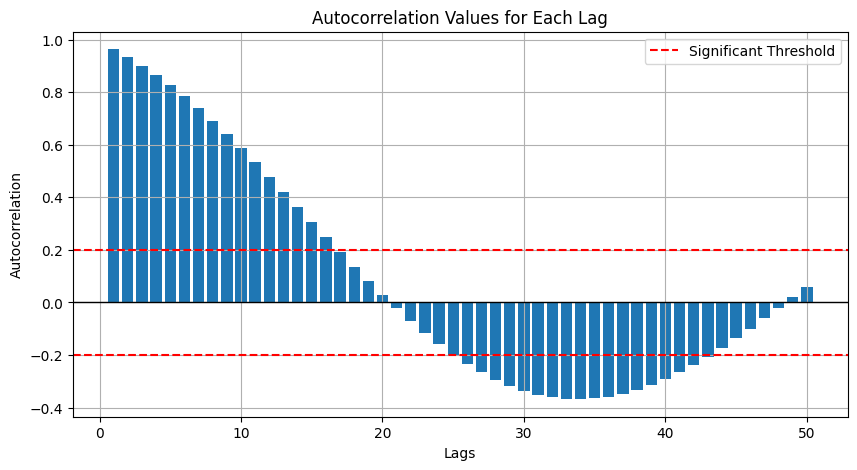

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(range(1, max_lag + 1), autocorr_values)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Threshold')
plt.axhline(y=-0.2, color='red', linestyle='--')
plt.title('Autocorrelation Values for Each Lag')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

#LSTM Setup

In [8]:
import torch

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
      batch_size = x.size(0)
      h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      lstm_out, (h_n, _) = self.lstm(x, (h0, c0))
      return self.fc(lstm_out[:, -1, :])

#Linear LSTM Built

In [10]:
def initialize_model(input_size, neurons, num_layers = 1, learning_rate = 1e-3):
  model = LSTMModel(input_size=input_size, hidden_size=neurons, num_layers=num_layers).to(device)
  criterion = nn.SmoothL1Loss(beta=1.0)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, min_lr = 1e-5, threshold = 0.001)
  return model, criterion, optimizer, scheduler

In [11]:
def train_epoch(model, optimizer, criterion, train_loader):
  model.train(True)
  train_loss = 0

  for batch_idx, (batch_X, batch_Y) in enumerate(train_loader):
      batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs, batch_Y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() #Use Detach Function

  avg_train_loss = train_loss / len(train_loader)
  return avg_train_loss

In [12]:
def val_epoch(model, criterion, scheduler, val_loader):
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for batch_idx, (batch_X, batch_Y) in enumerate(val_loader):
          batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
          outputs = model(batch_X)
          loss = criterion(outputs, batch_Y)
          val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)
  scheduler.step(avg_val_loss)
  return avg_val_loss

In [13]:
def compute_error(model, X_test_tensor, Y_test_tensor, Y_scaler):
    model.eval()
    with torch.no_grad():
      outputs = model(X_test_tensor).cpu().numpy().flatten()
      outputs = Y_scaler.inverse_transform(outputs.reshape(-1, 1)).flatten()

      actual = Y_test_tensor.cpu().numpy().flatten()
      actual = Y_scaler.inverse_transform(actual.reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(actual, outputs))
    nrmse_mean = rmse / np.mean(actual)
    mae = mean_absolute_error(actual, outputs)
    return rmse, nrmse_mean, mae

In [14]:
class EarlyStopping:
    def __init__(self, patience, optimizer, min_delta = 1e-4):
        self.patience = patience
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.min_delta = min_delta
        self.min_lr = 1e-5
        self.optimizer = optimizer
        self.best_model_state = None

    def check(self, model, avg_val_loss):
        if (self.best_val_loss - avg_val_loss) > self.min_delta:
            self.best_val_loss = avg_val_loss
            self.patience_counter = 0
            self.best_model_state = model.state_dict()  # Save Ideal Model State
        else:
            self.patience_counter += 1
            current_lr = self.optimizer.param_groups[0]['lr']
            if self.patience_counter >= self.patience and current_lr <= self.min_lr:
                print("\n🛑 Early stopping triggered. Restoring best model...")
                model.load_state_dict(self.best_model_state)  # Restore best model
                return True  # Signal to Stop Training
        return False  # Continue Training

In [15]:
def run_model(model, epochs, scheduler, optimizer, criterion, train_loader, val_loader, X_test_tensor, Y_test_tensor, Y_scaler):
  torch.cuda.empty_cache()
  early_stopping = EarlyStopping(patience=10, optimizer = optimizer, min_delta = 1e-5)
  print("Training Model", model)

  lowest_rmse, lowest_nrmse = float('inf'), float('inf')

  for epoch in range(epochs):
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f"\n🔄 Epoch [{epoch+1}/{epochs}] - Training...")

    prev_lr = optimizer.param_groups[0]['lr']

    avg_train_loss = train_epoch(model, optimizer, criterion, train_loader)
    avg_val_loss = val_epoch(model, criterion, scheduler, val_loader)
    rmse, nrmse, mae = compute_error(model, X_test_tensor, Y_test_tensor, Y_scaler)

    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != prev_lr:
        print(f"📉 Learning Rate Reduced at Epoch {epoch + 1}: New LR = {current_lr:.6f}")
        prev_lr = current_lr

    if rmse < lowest_rmse:
      lowest_rmse = rmse
      lowest_nrmse = nrmse

    stop = early_stopping.check(model, avg_val_loss)
    if stop: break

    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
      print(f"📉 Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, RMSE: {rmse:.4f}, nRMSE: {nrmse:.4f}")

  performance = {
        'model_config': model,
        'rmse': lowest_rmse,
        'nrmse': lowest_nrmse,
        'mae': mae
          }
  return performance

#Baseline Model (Entire Feature Set)

In [16]:
def create_3D_sequences(data, timesteps):
    X = []
    Y = []
    data_np = data.drop('Target', axis=1).to_numpy()  # Exclude 'Target' from X
    target_np = data['Target'].to_numpy()             # Isolate 'Target'

    for i in range(len(data_np) - timesteps):
        X.append(data_np[i:i + timesteps])
        Y.append(target_np[i + timesteps])

    return np.array(X), np.array(Y)

In [17]:
timesteps = 30
X, Y = create_3D_sequences(data, timesteps)

In [18]:
def data_split_scale(X, Y):
  train = int(0.8 * len(X))  # 80% Train
  test = len(X) - train #20% test

  X_train, Y_train = X[:train], Y[:train]
  X_test, Y_test = X[train:], Y[train:]

  X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  X_scaler = MinMaxScaler(feature_range=(-1,1))
  Y_scaler = MinMaxScaler(feature_range=(-1,1))

  #Flattening Dataset For Scaling

  X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
  X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

  X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
  X_test_scaled = X_scaler.transform(X_test_reshaped)

  #Reshaping Back Into 3D Dataset

  X_train_scaled = X_train_scaled.reshape(X_train.shape)
  X_test_scaled = X_test_scaled.reshape(X_test.shape)

  Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1,1))
  Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1,1))

  return X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler

X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler = data_split_scale(X, Y)

In [19]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((108417, 30, 26), (27105, 30, 26), (108417, 1), (27105, 1))

In [20]:
class TimeSeriesData(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [21]:
def data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256):
  X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32).to(device)
  Y_train_tensor = torch.tensor(Y_train_scaled, dtype = torch.float32).to(device)
  X_test_tensor = torch.tensor(X_test_scaled, dtype = torch.float32).to(device)
  Y_test_tensor = torch.tensor(Y_test_scaled, dtype = torch.float32).to(device)
  train_dataset = TimeSeriesData(X_train_tensor, Y_train_tensor)
  test_dataset = TimeSeriesData(X_test_tensor, Y_test_tensor)
  train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
  test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

  return X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader

In [22]:
from itertools import product

param_grid = {
    'neurons': [32, 64, 128, 256],
    'learning_rate': [1e-3],
    'batch_size': [32, 64, 128, 256]
}

X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader = data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256)

lowest_rmse = float('inf')

for params in product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nEvaluating Configuration: {config}")
    model, criterion, optimizer, scheduler = initialize_model(X_train_tensor.shape[2], config['neurons'], num_layers = config['num_layers'], learning_rate = config['learning_rate'])
    batch_size = config['batch_size']
    epochs = 300

    print(f"Model: {model}, Batch Size: {batch_size}, Total Epochs: {epochs}")

    train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

    performance = run_model(model, epochs, scheduler, optimizer, criterion, train_loader, test_loader, X_test_tensor, Y_test_tensor, Y_scaler)
    print(f"Lowest RMSE: {performance['rmse']:.4f}, nRMSE: {performance['nrmse']:.4f}")

    if performance['rmse'] < lowest_rmse:
        lowest_rmse = performance['rmse']
        lowest_nrmse = performance['nrmse']
        ideal_config = config
        ideal_model = performance['model_config']

print(f"\nBest Configuration: {ideal_config}")


Evaluating Configuration: {'neurons': 32, 'learning_rate': 0.001, 'batch_size': 256, 'num_layers': 1}
Model: LSTMModel(
  (lstm): LSTM(26, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), Batch Size: 256, Total Epochs: 300
Training Model LSTMModel(
  (lstm): LSTM(26, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

🔄 Epoch [10/300] - Training...
📉 Epoch [10/300] - Train Loss: 0.024242, Val Loss: 0.022132, RMSE: 105.1744, nRMSE: 0.2550
📉 Learning Rate Reduced at Epoch 19: New LR = 0.000300

🔄 Epoch [20/300] - Training...
📉 Epoch [20/300] - Train Loss: 0.023329, Val Loss: 0.021381, RMSE: 103.3057, nRMSE: 0.2504

🔄 Epoch [30/300] - Training...
📉 Epoch [30/300] - Train Loss: 0.022687, Val Loss: 0.021111, RMSE: 102.6791, nRMSE: 0.2489
📉 Learning Rate Reduced at Epoch 38: New LR = 0.000090

🔄 Epoch [40/300] - Training...
📉 Epoch [40/300] - Train Loss: 0.022347, Val Loss: 0.020969, RMSE: 102.3489, nRMSE: 0.2481
📉 Learning Ra

#Feature Selection

In [23]:
data

,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,Asymmetry,Clearsky DHI,...,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs,Target
local_datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,0.62,46,...,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451,241.0
2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,0.62,47,...,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561,253.0
2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,0.62,48,...,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568,251.0
2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,0.62,49,...,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596,273.0
2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,0.62,50,...,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:20:00,2023,12,31,21,20,4.3,1.16,0.029,0.62,50,...,46.80,70.43,0.86,0.12,827,0.6,52,1.1,0.795,203.0
2023-12-31 14:30:00,2023,12,31,21,30,4.0,1.16,0.029,0.62,49,...,47.79,71.52,0.86,0.12,827,0.6,57,1.0,0.784,183.0
2023-12-31 14:40:00,2023,12,31,21,40,3.7,1.15,0.029,0.62,47,...,55.02,72.66,0.86,0.12,827,0.7,61,0.8,0.834,153.0


In [24]:
corr_matrix = data.corr()
target_corr = corr_matrix['Target'].sort_values(ascending = False)
print(target_corr)

Target                1.000000
GHI                   0.864569
Clearsky GHI          0.705739
DNI                   0.569800
Clearsky DNI          0.551220
Kcs                   0.430004
Temperature           0.391572
Clearsky DHI          0.330061
Hour                  0.155588
Pressure              0.146356
DHI                   0.143099
Alpha                 0.062926
Wind Speed            0.051270
Dew Point             0.043885
Precipitable Water    0.034826
Minute                0.002542
Day                  -0.001205
Ozone                -0.011929
AOD                  -0.018560
Year                 -0.021221
Asymmetry            -0.024055
Month                -0.034608
Wind Direction       -0.060534
Surface Albedo       -0.107599
SSA                  -0.112210
Relative Humidity    -0.483894
Solar Zenith Angle   -0.680480
Name: Target, dtype: float64


In [25]:
selected_features = target_corr[abs(target_corr) > 0.3].index.tolist()
print(selected_features)

['Target', 'GHI', 'Clearsky GHI', 'DNI', 'Clearsky DNI', 'Kcs', 'Temperature', 'Clearsky DHI', 'Relative Humidity', 'Solar Zenith Angle']


In [26]:
trainSet = data.drop('Target', axis = 1, inplace = False)
targetSet = data[['Target']]
X, Y = trainSet.to_numpy(), targetSet.to_numpy()

In [27]:
train = int(0.8 * len(X))  # 80% Train
test = len(X) - train #20% test

X_train, Y_train = X[:train], Y[:train]
X_test, Y_test = X[train:], Y[train:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

X_scaler = MinMaxScaler(feature_range=(-1,1))
Y_scaler = MinMaxScaler(feature_range=(-1,1))

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1,1))
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1,1))

In [28]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((108441, 26), (27111, 26), (108441, 1), (27111, 1))

In [29]:
from sklearn.ensemble import ExtraTreesRegressor

# Train model
etr = ExtraTreesRegressor()
Y_train_scaled = Y_train_scaled.ravel()
etr.fit(X_train_scaled, Y_train_scaled)

# Get feature importance
importances = etr.feature_importances_
trainSet = data.drop('Target', axis = 1, inplace = False)
featuresTrain = trainSet.columns.tolist()

# Sort and plot
feat_imp = pd.Series(importances, index=featuresTrain).sort_values(ascending=False)
print(feat_imp)
top_features = feat_imp[feat_imp > 0.01].index
print(top_features)

GHI                   0.502346
Clearsky GHI          0.119849
Hour                  0.099833
Solar Zenith Angle    0.065731
DNI                   0.063736
Kcs                   0.018111
DHI                   0.011781
Clearsky DNI          0.009311
Relative Humidity     0.008829
Wind Direction        0.008383
SSA                   0.007963
Wind Speed            0.007040
Pressure              0.006937
Precipitable Water    0.006640
Day                   0.006340
Temperature           0.006322
Ozone                 0.006175
Alpha                 0.005844
Year                  0.005746
Minute                0.005642
Dew Point             0.005559
Clearsky DHI          0.004924
AOD                   0.004763
Surface Albedo        0.004532
Asymmetry             0.004109
Month                 0.003555
dtype: float64
Index(['GHI', 'Clearsky GHI', 'Hour', 'Solar Zenith Angle', 'DNI', 'Kcs',
       'DHI'],
      dtype='object')


In [30]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
Y_train_scaled = Y_train_scaled.ravel()
xgb.fit(X_train_scaled, Y_train_scaled)

# Get feature importance
importances = xgb.feature_importances_
trainSet = data.drop('Target', axis = 1, inplace = False)
featuresTrain = trainSet.columns.tolist()

# Sort and plot
feat_imp = pd.Series(importances, index=featuresTrain).sort_values(ascending=False)
print(feat_imp)
top_features = feat_imp[feat_imp > 0.01].index
print(top_features)

GHI                   0.799834
Hour                  0.100807
Clearsky GHI          0.010124
SSA                   0.006721
Solar Zenith Angle    0.005656
Clearsky DNI          0.005560
Relative Humidity     0.005542
Month                 0.004980
Kcs                   0.004463
Pressure              0.004258
Precipitable Water    0.004210
Wind Direction        0.004081
Temperature           0.003872
Asymmetry             0.003859
Dew Point             0.003590
Ozone                 0.003486
Surface Albedo        0.003401
Day                   0.003288
DNI                   0.003188
Alpha                 0.003143
DHI                   0.003089
AOD                   0.002988
Wind Speed            0.002938
Clearsky DHI          0.002792
Year                  0.002728
Minute                0.001403
dtype: float32
Index(['GHI', 'Hour', 'Clearsky GHI'], dtype='object')


In [31]:
from sklearn.feature_selection import mutual_info_regression

def select_features_by_mutual_info(df, target, threshold=0.01):
    """
    Selects features based on mutual information with the target variable.

    Parameters:
        df (pd.DataFrame): DataFrame containing all features and target.
        target (str): Name of the target column.
        threshold (float): Minimum MI score required to keep a feature.

    Returns:
        selected_features (list): List of selected features.
        mi_scores (pd.Series): Mutual information scores for all features.
    """

    # Compute mutual information scores
    mi_scores = mutual_info_regression(trainSet, targetSet)

    # Convert to a Pandas Series for better visualization
    mi_scores = pd.Series(mi_scores, index=trainSet.columns).sort_values(ascending=False)

    # Select features above the threshold
    selected_features = mi_scores[mi_scores > threshold].index.tolist()

    return selected_features, mi_scores

# Example Usage
selected_features, mi_scores = select_features_by_mutual_info(data, target="target_variable", threshold=0.01)

# Print selected features
print("Selected Features:", selected_features)

# Show MI scores for all features
print(mi_scores)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selected Features: ['GHI', 'Clearsky GHI', 'Solar Zenith Angle', 'Hour', 'DHI', 'DNI', 'Clearsky DNI', 'Clearsky DHI', 'Relative Humidity', 'Month', 'Kcs', 'Temperature', 'AOD', 'Dew Point', 'SSA', 'Wind Direction', 'Surface Albedo', 'Alpha', 'Precipitable Water', 'Ozone', 'Asymmetry', 'Pressure', 'Wind Speed']
GHI                   0.931037
Clearsky GHI          0.819457
Solar Zenith Angle    0.657845
Hour                  0.343929
DHI                   0.321629
DNI                   0.310813
Clearsky DNI          0.273209
Clearsky DHI          0.250279
Relative Humidity     0.149710
Month                 0.142972
Kcs                   0.132758
Temperature           0.114350
AOD                   0.092631
Dew Point             0.058124
SSA                   0.049408
Wind Direction        0.048196
Surface Albedo        0.047234
Alpha                 0.044775
Precipitable Water    0.033421
Ozone                 0.030954
Asymmetry             0.024862
Pressure              0.020452
Wind 

#Testing Ground

In [32]:
data.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Alpha', 'AOD',
       'Asymmetry', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Dew Point', 'DHI', 'DNI', 'GHI', 'Ozone', 'Relative Humidity',
       'Solar Zenith Angle', 'SSA', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Kcs', 'Target'],
      dtype='object')

In [89]:
trainSet = data[['GHI', 'Clearsky GHI', 'Solar Zenith Angle', 'DNI',
    'Hour', 'Month', 'Relative Humidity', 'Kcs', 'Temperature', 'SSA', 'Pressure',
    'Clearsky DNI', 'DHI', 'Dew Point', 'Precipitable Water', 'Target']]

In [76]:
trainSet = data[['Hour', 'Month','DHI', 'GHI', 'Clearsky GHI', 'Solar Zenith Angle', 'DNI', 'SSA', 'Relative Humidity', 'Kcs', 'Target']]

In [90]:
trainSet

,GHI,Clearsky GHI,Solar Zenith Angle,DNI,Hour,Month,Relative Humidity,Kcs,Temperature,SSA,Pressure,Clearsky DNI,DHI,Dew Point,Precipitable Water,Target
local_datetime,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,142,315,72.17,27,16,1,34.07,0.451,-1.2,0.91,830,878,133,-15.1,0.4,241.0
2018-01-01 09:40:00,189,337,71.05,85,16,1,34.81,0.561,-0.8,0.91,829,894,161,-14.4,0.4,253.0
2018-01-01 09:50:00,204,359,69.98,95,16,1,33.56,0.568,-0.3,0.91,829,907,171,-14.4,0.4,251.0
2018-01-01 10:00:00,226,379,68.98,115,17,1,32.60,0.596,0.1,0.91,829,919,185,-14.4,0.4,273.0
2018-01-01 10:10:00,241,397,68.04,114,17,1,31.68,0.607,0.5,0.91,829,929,198,-14.4,0.4,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:20:00,271,341,70.43,385,21,12,46.80,0.795,4.3,0.86,827,869,142,-6.1,0.6,203.0
2023-12-31 14:30:00,251,320,71.52,380,21,12,47.79,0.784,4.0,0.86,827,854,131,-6.1,0.6,183.0
2023-12-31 14:40:00,246,295,72.66,448,21,12,55.02,0.834,3.7,0.86,827,830,112,-4.5,0.7,153.0


In [91]:
timesteps = 30
X, Y = create_3D_sequences(trainSet, timesteps)

In [92]:
X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler = data_split_scale(X, Y)

In [93]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((108417, 30, 15), (27105, 30, 15), (108417, 1), (27105, 1))

In [94]:
from itertools import product
param_grid = {
    'neurons': [128],
    'learning_rate': [1e-3],
    'num_layers': [1]
}

X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader = data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256)

lowest_rmse = float('inf')

for params in product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nEvaluating Configuration: {config}")
    model, criterion, optimizer, scheduler = initialize_model(X_train_tensor.shape[2], config['neurons'], num_layers = config['num_layers'], learning_rate = config['learning_rate'])
    batch_size = 256 #config['batch_size']
    epochs = 150 #config['epochs']

    print(f"Model: {model}, Batch Size: {batch_size}, Total Epochs: {epochs}")

    train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

    performance = run_model(model, epochs, scheduler, optimizer, criterion, train_loader, test_loader, X_test_tensor, Y_test_tensor, Y_scaler)
    print(f"Lowest RMSE: {performance['rmse']:.4f}, nRMSE: {performance['nrmse']:.4f}")

    if performance['rmse'] < lowest_rmse:
        lowest_rmse = performance['rmse']
        lowest_nrmse = performance['nrmse']
        ideal_config = config
        ideal_model = performance['model_config']

print(f"\nBest Configuration: {ideal_config}")


Evaluating Configuration: {'neurons': 128, 'learning_rate': 0.001, 'num_layers': 1}
Model: LSTMModel(
  (lstm): LSTM(15, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), Batch Size: 256, Total Epochs: 150
Training Model LSTMModel(
  (lstm): LSTM(15, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
📉 Learning Rate Reduced at Epoch 7: New LR = 0.000300

🔄 Epoch [10/150] - Training...
📉 Epoch [10/150] - Train Loss: 0.024485, Val Loss: 0.021414, RMSE: 103.4599, nRMSE: 0.2508

🔄 Epoch [20/150] - Training...
📉 Epoch [20/150] - Train Loss: 0.023861, Val Loss: 0.021184, RMSE: 102.8325, nRMSE: 0.2493

🔄 Epoch [30/150] - Training...
📉 Epoch [30/150] - Train Loss: 0.023469, Val Loss: 0.021025, RMSE: 102.4332, nRMSE: 0.2483

🔄 Epoch [40/150] - Training...
📉 Epoch [40/150] - Train Loss: 0.023267, Val Loss: 0.020888, RMSE: 102.0965, nRMSE: 0.2475

🔄 Epoch [50/150] - Training...
📉 Epoch [50/150] - Train Loss: 0.023128, Val Loss: 